In [21]:
# to make local package be able to import in notebook
%run initlibs.py QuantTradingResearch dark

from tools.charting.plot_helpers import *
from tools.analysis.timeseries import *
from tools.analysis.tools import retain_columns_and_join, scols, srows
from tools.analysis.data import make_forward_returns_matrix
from tools.loaders.binance import load_binance_data
from tools.loaders.yahoo_finance import load_yahoo_daily_data

from statsmodels.regression.linear_model import OLS

# Gaps model

It'd be interesting to see if daily opening gap has any impact on day's direction for crypto market.
Here as gap we consider difference between previuos day's close and current day open expressed as ratio to prev day close:
$$
 G_t = \frac{O_t}{C_{t-1}} - 1
$$
In stocks market it's used as indicator of day's movement and it's said that price usualy reverts after significant opening gap in direction opposite to gap.
So if we see day's open is 1% up compared to previous close so probably price will cover this gap and fall back so we need to take short position. And vice verse for negative gap.

In [37]:
# loading all available data
data = load_binance_data(['BTCUSDT', 'XRPUSDT', 'ETHUSDT', 'EOSUSDT', 'LTCUSDT'], '1d', start='2018')
closes = retain_columns_and_join(data, 'close')

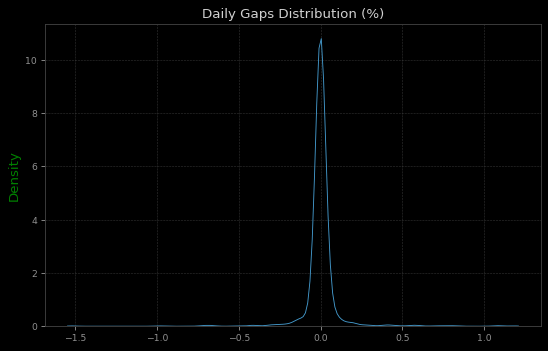

In [38]:
# ds = data['BTCUSDT']
ds = data['ETHUSDT']
gaps = ds.open / ds.close.shift(1) - 1
dsg = scols(ds, gaps.rename('gap'), (ds.close/ds.open - 1).rename('ret'))

sns.kdeplot(100*gaps, cut=1); plt.title('Daily Gaps Distribution (%)');

We select days that have gap on open if gap exceeds some threshold value (let's say 0.01%)

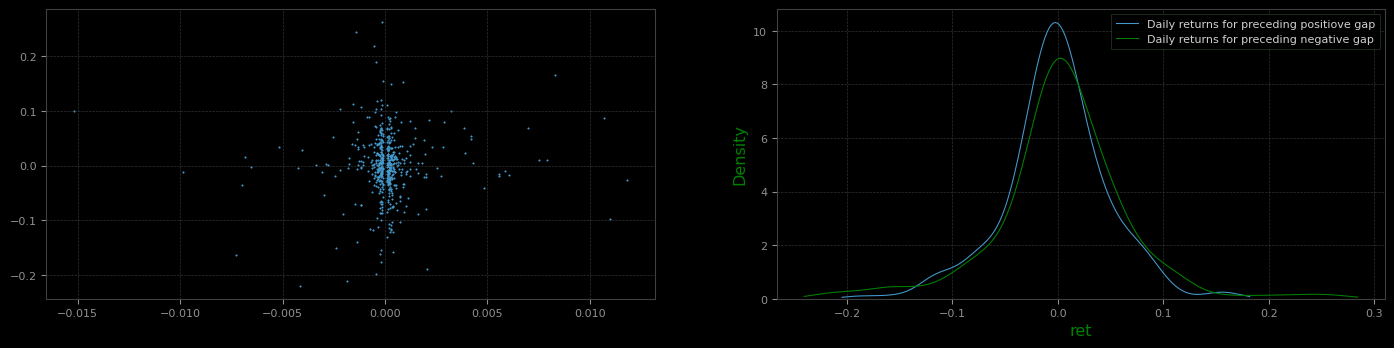

In [39]:
gaps_days = dsg[abs(dsg.gap) > 0.01/100]

fig(18, 4)
sbp(12,1); plt.scatter(gaps_days.gap, gaps_days.ret, s=1)
sbp(12,2);
pos_g, neg_g = dsg[dsg.gap > 0.01/100], dsg[dsg.gap < -0.01/100]
sns.kdeplot(pos_g.ret, cut=1, label='Daily returns for preceding positiove gap')
sns.kdeplot(neg_g.ret, cut=1, label='Daily returns for preceding negative gap')
plt.legend();

Unfortunatelly it doesn't look like having any significant impact on day's direction. What if we'd trade reversals on gaps ?

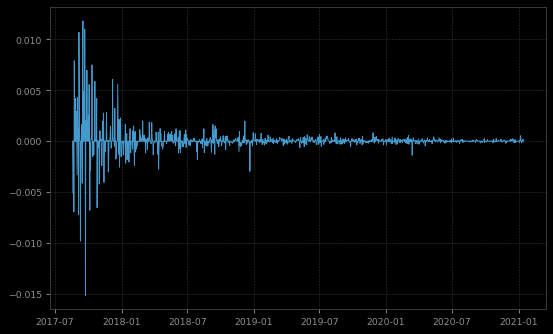

In [40]:
plt.plot(dsg.gap)
# plt.plot(T)
# plt.plot(-T)

From pic above we can see that gap's spread narrowed recent times, so we could try to use dynamic threshold based on something like standard deviation.

Let's see what's impact of gap's value using linear regression

In [12]:
M = scols(dsg.ret, 
          scols(dsg.ret.shift(1),
                dsg.gap, 
                dsg.gap.rolling(14).std(),
                dsg.ret.rolling(14).std().shift(1),
                names=['prev_day_return', 
                       'gap', 
                       'gapVolatility',
                       'returnsVolatility'
                      ]),
          keys=['Y', 'X']).dropna()
lm = OLS(M.Y, M.X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    ret   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              2.387
Date:                Fri, 15 Jan 2021   Prob (F-statistic):                      0.0495
Time:                        12:22:58   Log-Likelihood:                          1727.1
No. Observations:                1136   AIC:                                     -3446.
Df Residuals:                    1132   BIC:                                     -3426.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
prev_day_return      -0.0781      0.030     -2.637      0.008      -0.136      -0.020
gap                   0.7102      1.343      0.529      0.597      -1.924       3.345
gapVolatility         0.7033      1.576      0.446      0.656      -2.390       3.796
returnsVolatility     0.0348      0.036      0.965      0.335      -0.036       0.106
==============================================================================
Omnibus:                      207.496   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2116.111
Skew:                          -0.515   Prob(JB):                         0.00
Kurtosis:                       9.606   Cond. No.                         54.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<hr/>
<font color='cyan'>We sell/buy every time when observed gap is above/below it's 2 standard deviations </font>
<hr/>

<font color='red'>Warn:</font> No any transaction costs are taken in account so estimation looks bit optimistic !

In [53]:
def trade_gaps(instrument, M, t):
    traded_s = -M.Y[M.X.gap > t * M.X.gapVolatility].ret
    traded_b = M.Y[M.X.gap < -t * M.X.gapVolatility].ret
    returns = srows(traded_b, traded_s, sort=True)
    if not returns.empty:
        plt.plot((returns + 1).cumprod(), label=f'{instrument} equity')
        plt.title(f'{instrument} gaps trading equity')
    return returns

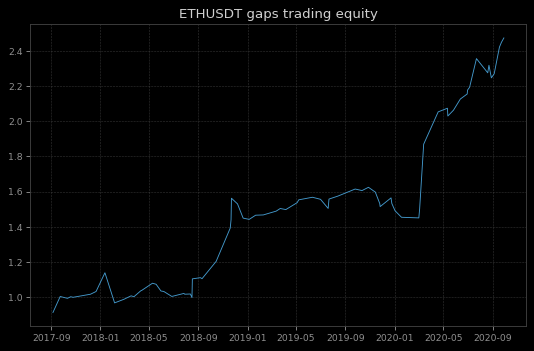

In [42]:
trade_gaps('ETHUSDT', M, 2);

# Test on all data and combine portfolio

Now let's see how it performs on every symbol we have in data and what if we'd trade equal weighted portfolio.

In [45]:
def run_tests(instrument, data, Vt, verbose=True):
    ds = data[instrument]
    gaps = ds.open / ds.close.shift(1) - 1
    dsg = scols(ds, gaps.rename('gap'), (ds.close/ds.open - 1).rename('ret'))
    min_sign, best_period_M, best_period = 1e0, None, 0
    
    for period in range(5, 60): 
        M = scols(dsg.ret, 
                  scols(
                        dsg.gap, 
                        dsg.gap.rolling(period).std(),
                        names=[ 'gap',  'gapVolatility', ]), keys=['Y', 'X']).dropna()
        lm = OLS(M.Y, M.X).fit()
        t = lm.summary2()
        sv = t.tables[1].loc['gapVolatility']['P>|t|']
        if sv < min_sign:
            min_sign = sv
            best_period = period
            best_period_M = M
    if verbose:
        print(f' > {instrument} Best period: {best_period}')
    return trade_gaps(instrument, best_period_M, Vt)

 > BTCUSDT Best period: 29
 > XRPUSDT Best period: 17
 > ETHUSDT Best period: 29
 > EOSUSDT Best period: 14
 > LTCUSDT Best period: 6


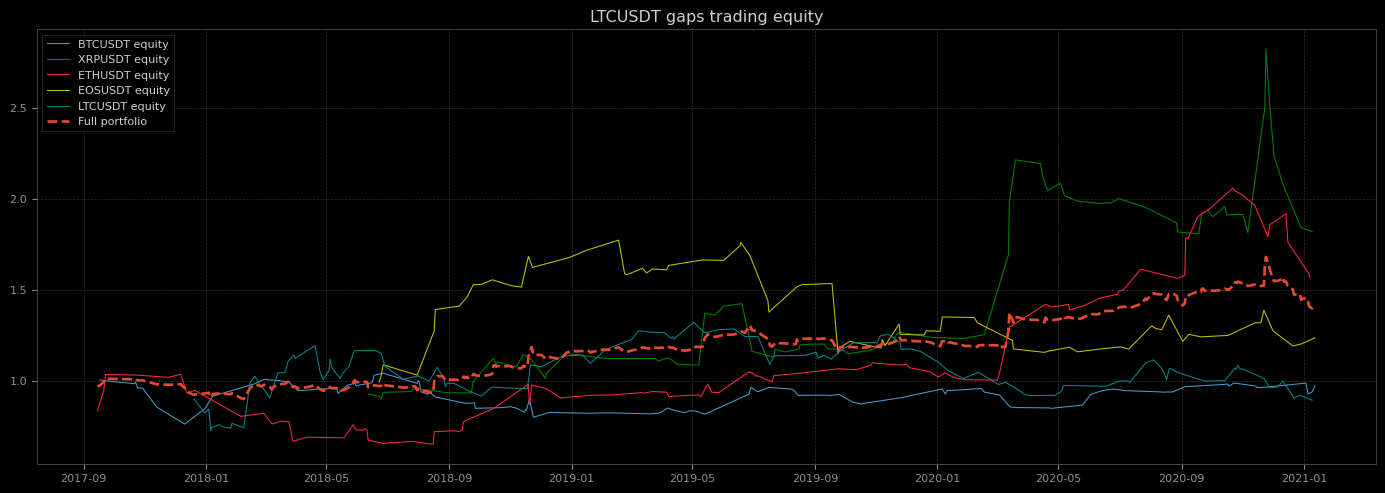

In [43]:
fig(18, 6)
eqts = {}

for i in data.keys():
    eqts[i] = run_tests(i, data, 1.8)
# plt.plot( (pd.DataFrame.from_dict(eqts).fillna(0).sum(axis=1) + 1).cumprod(), label='Full portfolio', lw=2, ls='--' )
plt.plot((pd.DataFrame.from_dict(eqts).fillna(0).mean(axis=1) + 1).cumprod(), label='Full portfolio', lw=2, ls='--' )
plt.legend();

# Test on stocks

In [44]:
holdings = pd.read_csv('../data/30-06-2020.csv', sep=';').dropna()
data = load_yahoo_daily_data(holdings.Ticker.values, '2016-01-01', )

XTSLA MSFUT BFB JWA HEIA LGFB LENB BFA LGFA FAU0 ESU0 

> Loaded 834 symbols


In [47]:
closes = retain_columns_and_join(data, 'close')

In [ ]:
fig(18, 6)
eqts = {}

for i in tqdm(data.keys()):
    eqts[i] = run_tests(i, data, 1.8, verbose=False)
plt.legend();

Text(0.5, 1.0, 'Potfolio cumulative PnL')

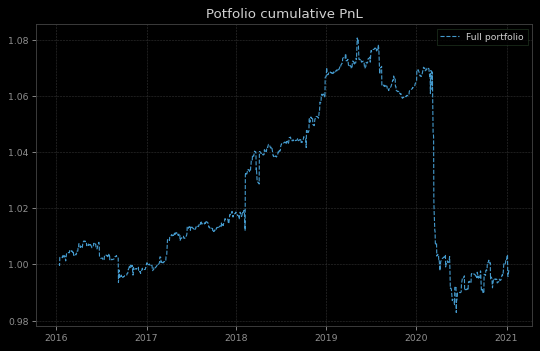

In [55]:
plt.plot((pd.DataFrame.from_dict(eqts).fillna(0).mean(axis=1) + 1).cumprod(), label='Full portfolio', lw=1, ls='--' )
plt.legend()
plt.title('Potfolio cumulative PnL');